In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN, validity_index
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from keybert import KeyBERT
from tqdm.auto import tqdm
import gc
import re


In [50]:
def clean_text_minimal(text):
    """Convertit en minuscules et nettoie les caractères spéciaux"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower().strip()
    text = re.sub(r'[^\w\s-]', ' ', text)  # Remplace la ponctuation par des espaces
    text = re.sub(r'\s+', ' ', text)       # Unifie les espaces multiples
    return text


In [51]:
def load_data(path):
    """Charge le fichier CSV avec nettoyage minimal"""
    with tqdm(total=1, desc="Chargement des données") as pbar:
        df = pd.read_csv(path, usecols=['Summary'], dtype={'Summary': 'string'})
        df['Summary'] = df['Summary'].fillna('').apply(clean_text_minimal)
        pbar.update(1)
    
    print(f"\nExemples après nettoyage :\n{df['Summary'].head(3)}")
    return df

In [ ]:
def generate_embeddings(texts):
    """Génère des embeddings par lots avec libération mémoire"""
    model = SentenceTransformer(
        'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        device='cpu',
        cache_folder='./cache1'
    )
    
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Embedding"):
        batch = texts[i:i+BATCH_SIZE]
        embeddings.append(model.encode(
            batch,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True,
            batch_size=32
        ))
        gc.collect()  # Libération mémoire explicite
    
    return np.vstack(embeddings)

In [83]:
def cluster_data(embeddings):
    """Pipeline complet de clustering"""
    # Réduction dimensionnelle
    with tqdm(total=1, desc="UMAP") as pbar:
        reducer = UMAP(
            n_components=N_COMPONENTS,
            n_neighbors=10,
            metric='cosine',
            low_memory=True
        )
        reduced_embeds = reducer.fit_transform(embeddings)
        pbar.update(1)
    
    # Clustering
    with tqdm(total=1, desc="HDBSCAN") as pbar:
        clusterer = HDBSCAN(
            min_cluster_size=max(30, int(len(embeddings)*0.0005)),
            min_samples=5,
            cluster_selection_epsilon=0.1,
            memory='./cache1'
        )
        clusters = clusterer.fit_predict(reduced_embeds)
        pbar.update(1)
    
    return clusters, reduced_embeds


In [78]:
def evaluate_clusters(embeddings, clusters, reduced_embeds):
    """Calcule les métriques clés avec gestion des erreurs"""
    metrics = {}
    
    # 1. Conversion des types pour HDBSCAN
    embeddings_float64 = np.array(embeddings, dtype=np.float64)
    clusters_int = clusters.astype(np.int32)
    
    # 2. DBCV Score (avec gestion d'erreur)
    try:
        metrics['DBCV'] = validity_index(embeddings_float64, clusters_int)
    except Exception as e:
        print(f"⚠ Erreur DBCV: {str(e)}")
        metrics['DBCV'] = None
    
    # 3. Silhouette Score (échantillonnage pour grandes datasets)
    sample_size = min(2000, len(embeddings))
    sample_idx = np.random.choice(len(embeddings), sample_size, replace=False)
    
    try:
        metrics['Silhouette'] = silhouette_score(
            reduced_embeds[sample_idx], 
            clusters[sample_idx]
        )
    except Exception as e:
        print(f"⚠ Erreur Silhouette: {str(e)}")
        metrics['Silhouette'] = None
    
    # 4. Nombre de clusters et bruit
    metrics['Clusters Identifiés'] = len(set(clusters)) - (1 if -1 in clusters else 0)
    metrics['Points de Bruit (%)'] = np.mean(clusters == -1) * 100
    
    return metrics

In [79]:
def visualize_results(clusters, reduced_embeds, df):
    """Affiche les visualisations clés"""
    # Configuration des plots
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution des clusters
    plt.subplot(221)
    pd.Series(clusters).value_counts().plot(kind='bar', logy=True)
    plt.title('Distribution des Tailles de Clusters (échelle log)')
    
    # 2. Projection UMAP
    plt.subplot(222)
    plt.scatter(
        reduced_embeds[:, 0], 
        reduced_embeds[:, 1], 
        c=clusters, 
        cmap='Spectral',
        s=5,
        alpha=0.5
    )
    plt.title('Projection 2D des Clusters')
    
    # 3. Exemples par cluster
    plt.subplot(212)
    plt.axis('off')
    sample_text = "\n".join([
        f"Cluster {c} : {df[df['Cluster']==c]['Summary'].iloc[0][:50]}..."
        for c in np.unique(clusters) if c != -1
    ])
    plt.text(0, 0.5, sample_text, fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

In [80]:
def extract_topics(df):
    """Identifie les topics principaux pour chaque cluster"""
    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    
    topics = {}
    for cluster in tqdm(sorted(df['Cluster'].unique()), desc="Extraction des topics"):
        if cluster == -1:
            continue
            
        cluster_texts = df[df['Cluster'] == cluster]['Summary'].tolist()
        if not cluster_texts:
            continue
            
        # Extraction des mots-clés
        keywords = kw_model.extract_keywords(
            ' '.join(cluster_texts),
            keyphrase_ngram_range=(1, 2),
            top_n=3
        )
        topics[cluster] = [kw[0] for kw in keywords]
    
    # Affichage des résultats
    print("\n🔍 Topics par cluster :")
    for cluster, kw in sorted(topics.items()):
        print(f"Cluster {cluster}: {', '.join(kw)}")
    
    return topics

In [ ]:
import os

# Configuration globale
BATCH_SIZE = 200  # Optimisé pour 16Go RAM
N_COMPONENTS = 10  # Dimension pour UMAP
MIN_CLUSTER_SIZE = 30  # Taille minimale des clusters
os.makedirs('./cache1', exist_ok=True)  # Dossier pour les caches

In [57]:
data_path = 'C:/Users/my.kassem/Desktop/exploratory data analysis/df_filtre_status_type_description_resolution_copy.csv'
df = load_data(data_path)

Chargement des données:   0%|          | 0/1 [00:00<?, ?it/s]


Exemples après nettoyage :
0    caceis-prod-in-cp - licence expirée depuis le ...
1         tst - manual override audit must be retested
2                                  can t start workers
Name: Summary, dtype: object


In [58]:
# Génération des embeddings
embeddings = generate_embeddings(df['Summary'].tolist())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\Tickets clustering\cache1\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.w

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding:   0%|          | 0/80 [00:00<?, ?it/s]

In [68]:
embeddings = np.array(embeddings, dtype=np.float64)  # Conversion explicite


In [84]:
# Clustering
clusters, reduced_embeds = cluster_data(embeddings)
df['Cluster'] = clusters


UMAP:   0%|          | 0/1 [00:00<?, ?it/s]

HDBSCAN:   0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
# Évaluation
metrics = evaluate_clusters(embeddings, clusters, reduced_embeds)
print("\n📊 Métriques d'Évaluation :")
for k, v in metrics.items():
    print(f"- {k}: {v if not isinstance(v, float) else f'{v:.2f}'}")

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity


📊 Métriques d'Évaluation :
- DBCV: -0.17
- Silhouette: 0.16674675047397614
- Clusters Identifiés: 106
- Points de Bruit (%): 29.85


C:\Users\my.kassem\AppData\Local\Temp\ipykernel_7792\1731838554.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


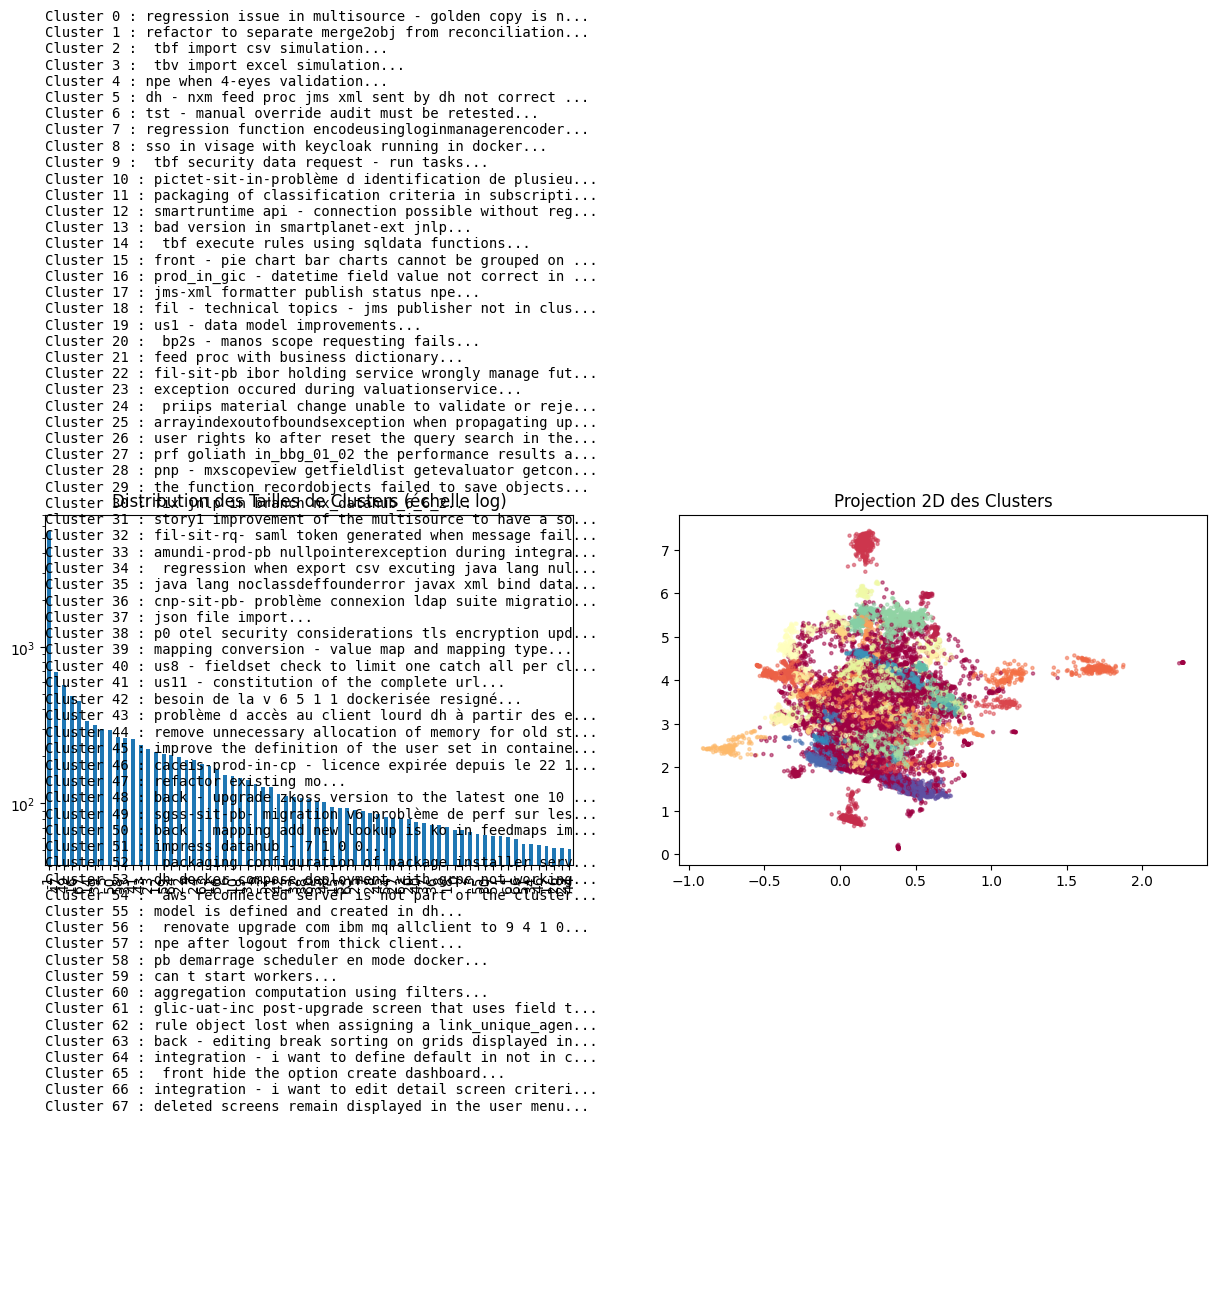

In [62]:
# Visualisation
visualize_results(clusters, reduced_embeds, df)

In [ ]:
# Extraction des topics
kw_model = KeyBERT()
topics = {}
for cl_id in tqdm(set(clusters) - {-1}, desc="Extraction des topics"):
    cluster_texts = df[df['Cluster'] == cl_id]['Summary'].tolist()
    keywords = kw_model.extract_keywords(
        " ".join(cluster_texts),
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=3
    )
    topics[cl_id] = ", ".join([kw[0] for kw in keywords])

In [86]:
# Récupération des outliers
outliers = df[df['Cluster'] == -1]

# Statistiques de base
print(f"Nombre total d'outliers: {len(outliers)}")
print(f"Pourcentage d'outliers: {len(outliers)/len(df)*100:.2f}%")

# Échantillon d'outliers pour inspection
outlier_samples = outliers['Summary'].sample(min(10, len(outliers)), random_state=42).tolist()
print("\nExemples d'outliers:")
print("- " + "\n- ".join(outlier_samples))

Nombre total d'outliers: 4770
Pourcentage d'outliers: 29.85%

Exemples d'outliers:
- component - grid options displayed in the overlay
-  pictet création de titres à la volée requête non aboutie avec statut et code retour faux - p0
- performance issue about label retrieving - vanguard 
- import export - creation of missing data automatically
- businessfieldreject not calculated for tech check error - format and error - mapping
- problem of sorting in export if we use a file publisher or the scope is empty - vanguard 
- sgss-sit-pb- definition de critere utilisant dans les arbres de decisions
- la correspondance entre les champs externe et interne semble s emmeler les pinceaux
- back - save query screen config
- service fileprocessor search_data on many columns
